In [9]:
from tensorflow.keras.datasets import mnist
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import argparse
import imutils
import cv2

In [10]:
# from sklearn.metrics import mean_squared_error
!pip install scikit-image
from skimage import measure

In [11]:
def load_az_dataset(datasetPath):
	data = []
	labels = []

	file = open(datasetPath)
	for row in file:

		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")

		image = image.reshape((28, 28))
		data.append(image)
		labels.append(label)
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")
	return (data, labels)


In [12]:
def load_mnist_dataset():

	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])
	return (data, labels)

In [13]:
import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [14]:
# Setting up hyperparameters
EPOCHS = 10
INIT_LR = 1e-1
BS = 128

In [15]:
# load the A-Z and MNIST datasets, respectively
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset('/content/drive/MyDrive/CV/A_Z Handwritten Data/A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...
11493376/11490434 [==============================] - 0s 0us/step


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
azLabels += 10
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])
# Resizing the image to 32 x 32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# Normalising the data
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [18]:
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
classTotals = labels.sum(axis=0)
classWeight = {}

for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

In [19]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [20]:
# Creating CNN model 
from keras.models import Sequential
#creating model object
model=Sequential()

from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

#adding layers and forming the model
model.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,32,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(36,activation="softmax"))

#compiling
model.compile(loss="categorical_crossentropy", optimizer='adamax',metrics=["accuracy"])


In [21]:
# training the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Epoch 1/10
2765/2765 [==============================] - 140s 39ms/step - loss: 3.6937 - accuracy: 0.7471 - val_loss: 0.2204 - val_accuracy: 0.9160
Epoch 2/10
2765/2765 [==============================] - 107s 39ms/step - loss: 1.0251 - accuracy: 0.9008 - val_loss: 0.2256 - val_accuracy: 0.9000
Epoch 3/10
2765/2765 [==============================] - 108s 39ms/step - loss: 0.8162 - accuracy: 0.9151 - val_loss: 0.2157 - val_accuracy: 0.9075
Epoch 4/10
2765/2765 [==============================] - 107s 39ms/step - loss: 0.7305 - accuracy: 0.9205 - val_loss: 0.1642 - val_accuracy: 0.9330
Epoch 5/10
2765/2765 [==============================] - 107s 39ms/step - loss: 0.6619 - accuracy: 0.9250 - val_loss: 0.1277 - val_accuracy: 0.9569
Epoch 6/10
2765/2765 [==============================] - 108s 39ms/step - loss: 0.6239 - accuracy: 0.9271 - val_loss: 0.1534 - val_accuracy: 0.9373
Epoch 7/10
2765/2765 [==============================] - 107s 39ms/step - loss: 0.5845 - acc

In [22]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [23]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.21      0.80      0.33      1381
           1       0.98      0.99      0.98      1575
           2       0.97      0.91      0.94      1398
           3       0.99      0.99      0.99      1428
           4       0.93      0.97      0.95      1365
           5       0.59      0.93      0.72      1263
           6       0.98      0.96      0.97      1375
           7       0.97      1.00      0.98      1459
           8       0.94      0.99      0.96      1365
           9       0.98      0.99      0.98      1392
           A       0.99      1.00      0.99      2774
           B       0.98      0.99      0.98      1734
           C       1.00      0.98      0.99      4682
           D       0.93      0.98      0.95      2027
           E       0.98      1.00      0.99      2288
           F       0.99      0.99      0.99       232
           G       0.95      0.97      0.96      115

In [24]:
# Low Level Vision
image = cv2.imread('/content/drive/MyDrive/CV/abcd.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [25]:
for c in cnts:
	(x, y, w, h) = cv2.boundingRect(c)
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		else:
			thresh = imutils.resize(thresh, height=32)
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))


In [26]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [27]:
save=[]
bosx=[]
for (pred, (x, y, w, h)) in zip(preds, boxes):	
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	print(prob)
	print(label)
	if(prob>0.99):
	  save.append(label)
	  bosx.append((x,y,w,h))

[INFO] A - 100.00%
0.9999993
A
[INFO] 1 - 99.03%
0.9902637
1
[INFO] O - 93.99%
0.93986803
O
[INFO] H - 100.00%
1.0
H
[INFO] V - 100.00%
1.0
V
[INFO] I - 100.00%
1.0
I
[INFO] P - 100.00%
1.0
P
[INFO] B - 100.00%
0.99999976
B
[INFO] 1 - 50.36%
0.5036368
1
[INFO] C - 100.00%
0.9999999
C
[INFO] Q - 100.00%
0.99997556
Q
[INFO] J - 100.00%
1.0
J
[INFO] V - 98.74%
0.9874349
V
[INFO] X - 100.00%
1.0
X
[INFO] D - 100.00%
0.99998903
D
[INFO] R - 100.00%
1.0
R
[INFO] K - 100.00%
1.0
K
[INFO] M - 99.98%
0.9998405
M
[INFO] Y - 99.29%
0.9929246
Y
[INFO] S - 99.92%
0.9992224
S
[INFO] L - 100.00%
1.0
L
[INFO] E - 100.00%
1.0
E
[INFO] 1 - 98.47%
0.9846941
1
[INFO] 1 - 73.16%
0.7316234
1
[INFO] T - 100.00%
0.9999988
T
[INFO] L - 99.79%
0.99794394
L
[INFO] Z - 100.00%
0.99999785
Z
[INFO] F - 100.00%
0.999997
F
[INFO] Y - 86.57%
0.8657317
Y
[INFO] G - 99.95%
0.9994867
G
[INFO] U - 100.00%
0.9999995
U
[INFO] N - 100.00%
1.0
N
[INFO] S - 71.47%
0.7146885
S
[INFO] 1 - 100.00%
0.9999968
1


In [28]:
# General information
print(len(save))
print(len(bosx))
print(save)
print(bosx[17])

27
27
['A', '1', 'H', 'V', 'I', 'P', 'B', 'C', 'Q', 'J', 'X', 'D', 'R', 'K', 'M', 'Y', 'S', 'L', 'E', 'T', 'L', 'Z', 'F', 'G', 'U', 'N', '1']
(168, 48, 25, 39)


In [30]:
image1 = cv2.imread('/content/Hello4.jpeg')
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [31]:
for c in cnts:
	(x, y, w, h) = cv2.boundingRect(c)
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		else:
			thresh = imutils.resize(thresh, height=32)
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [32]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

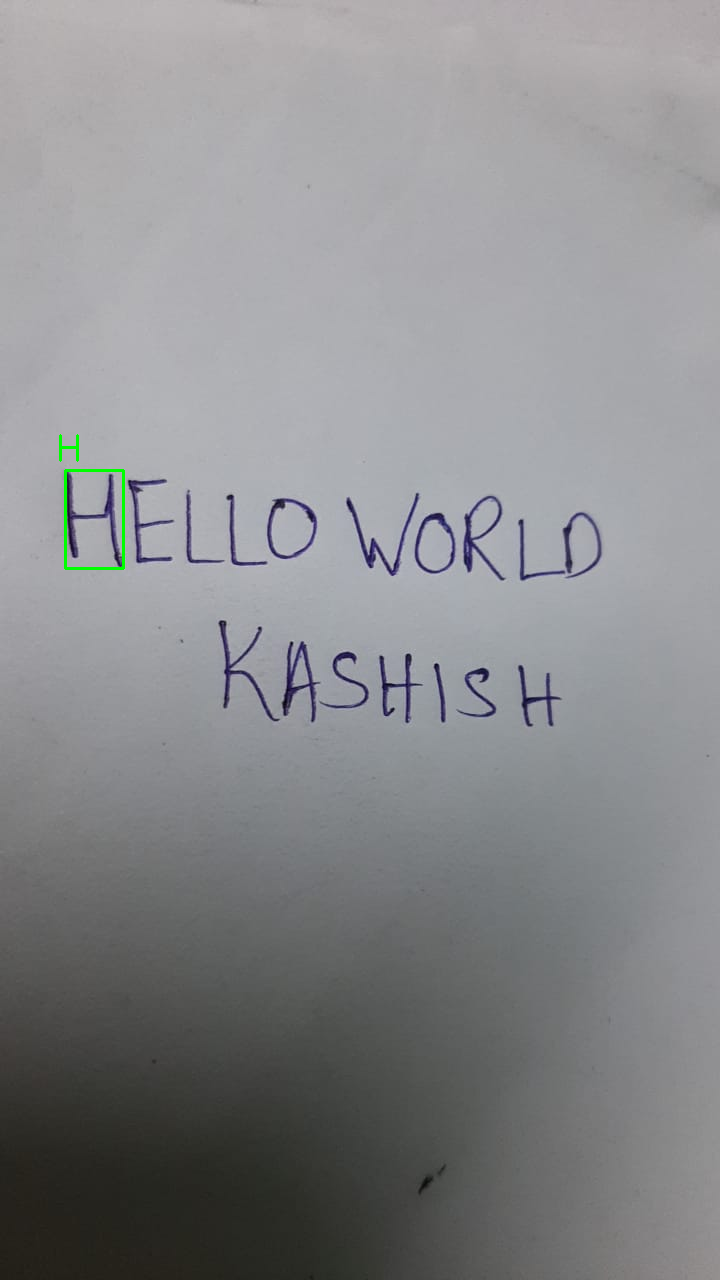

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


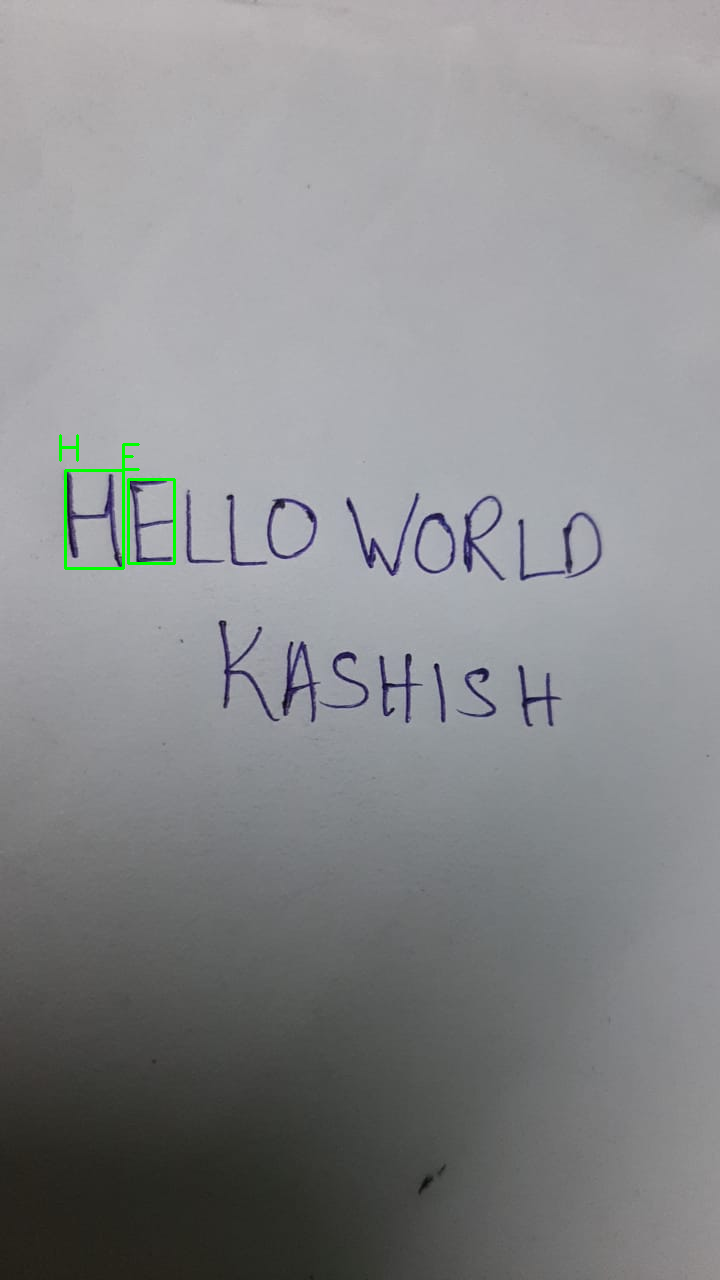

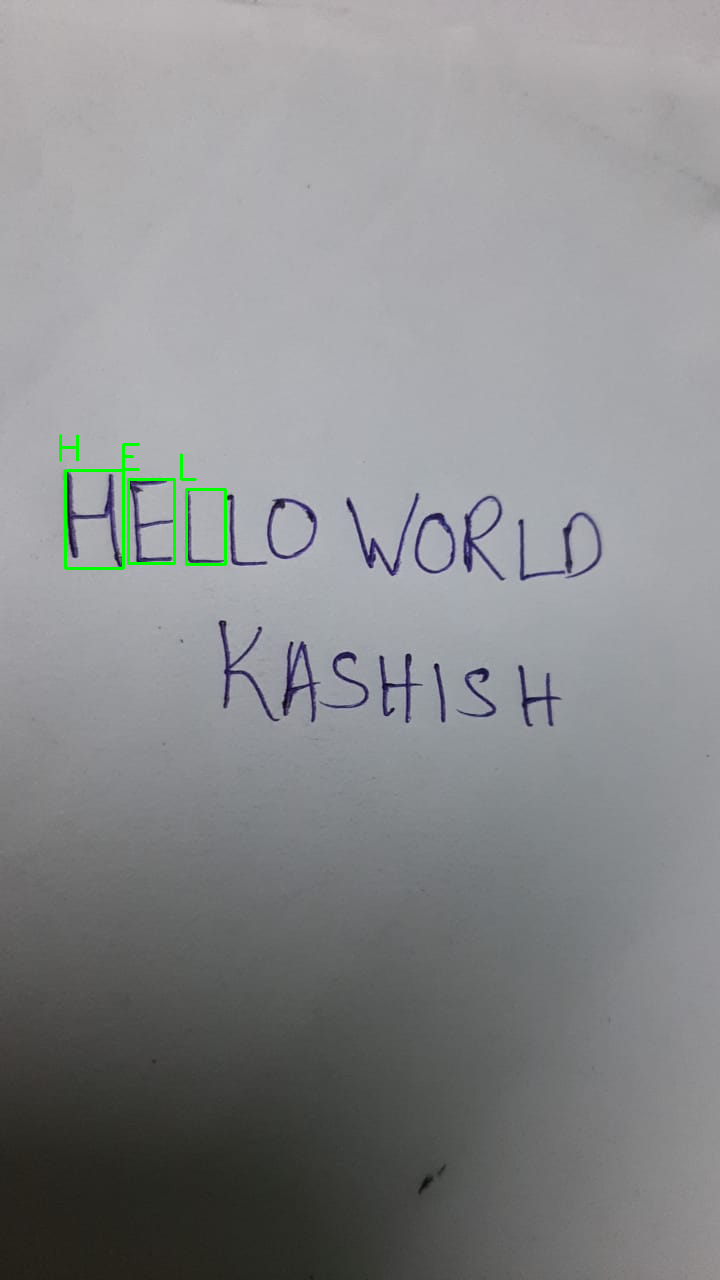

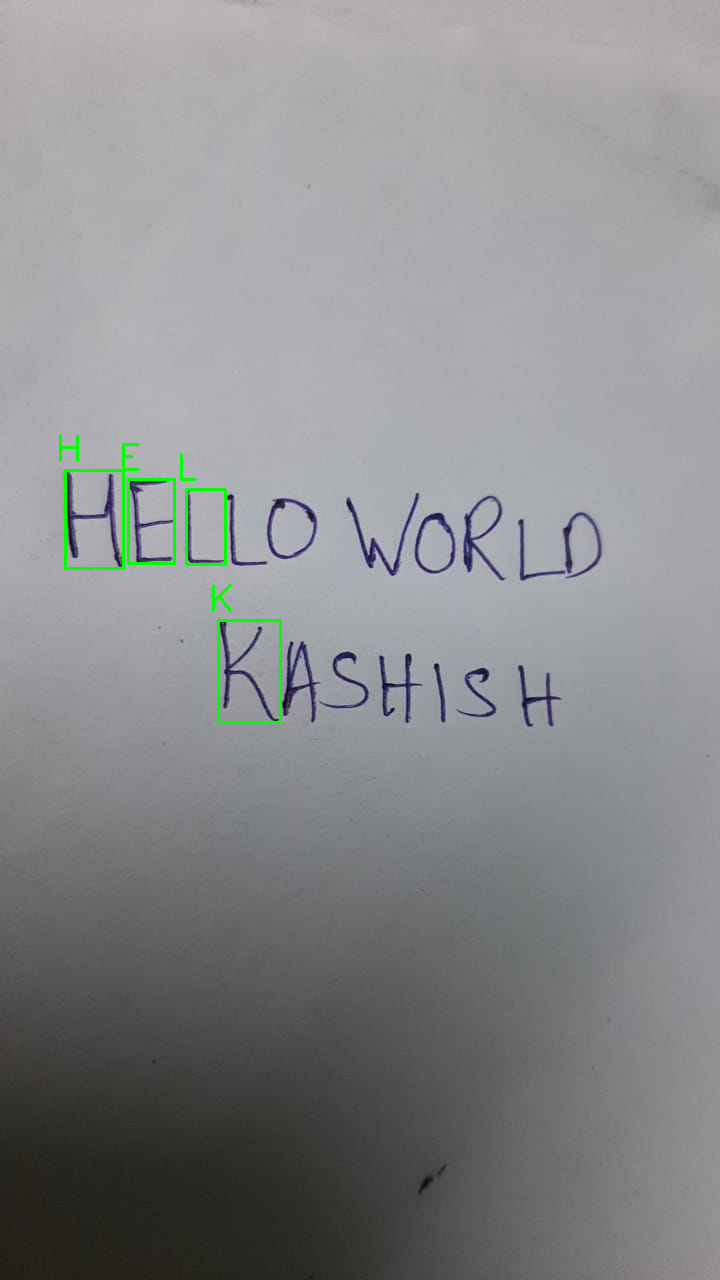

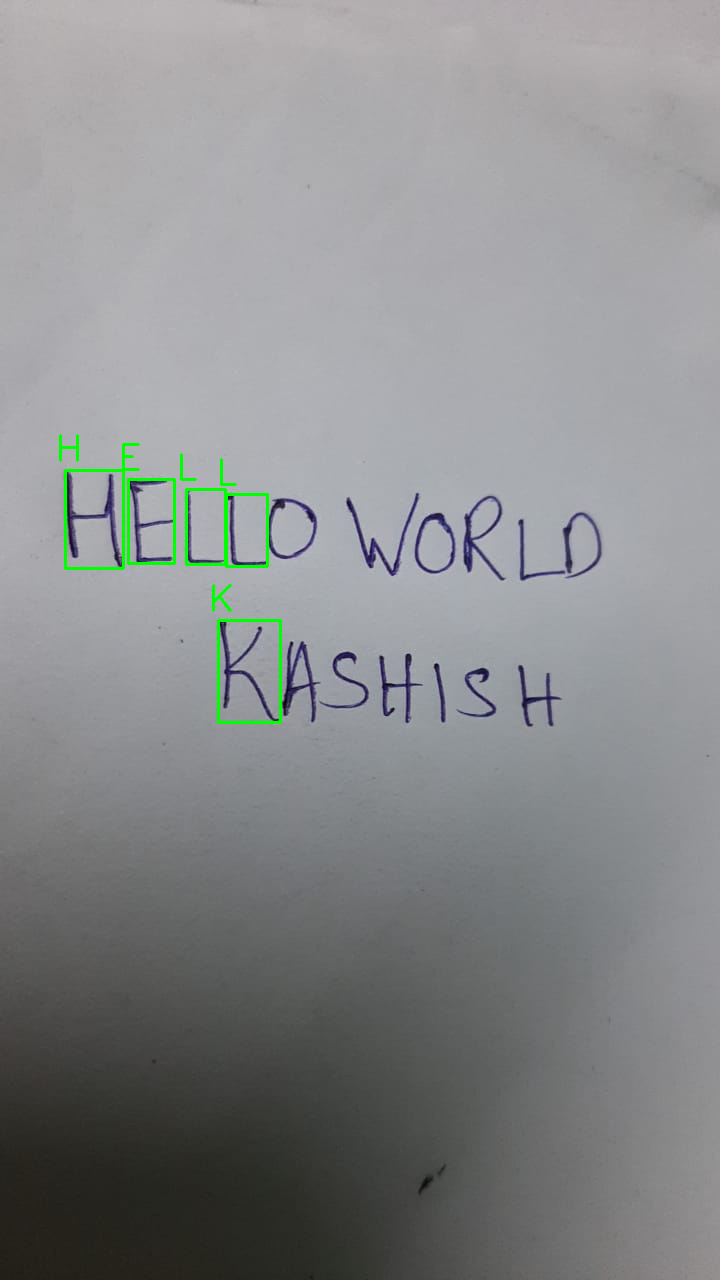

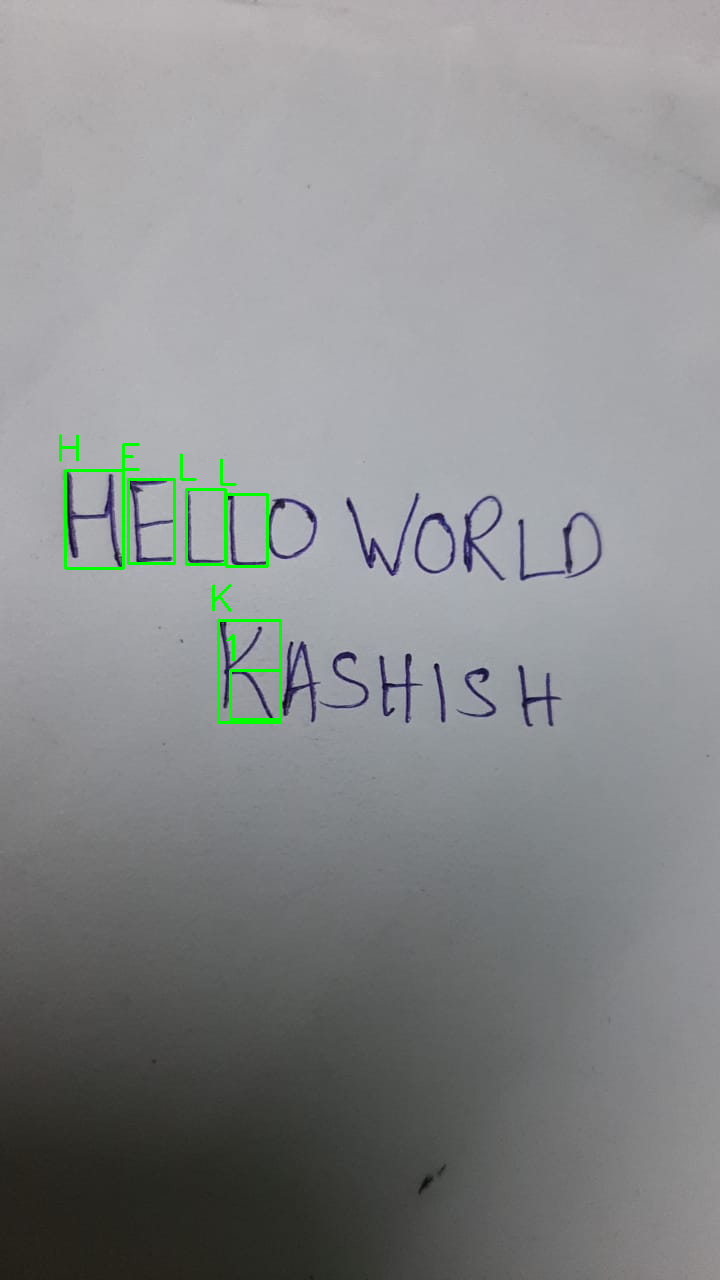

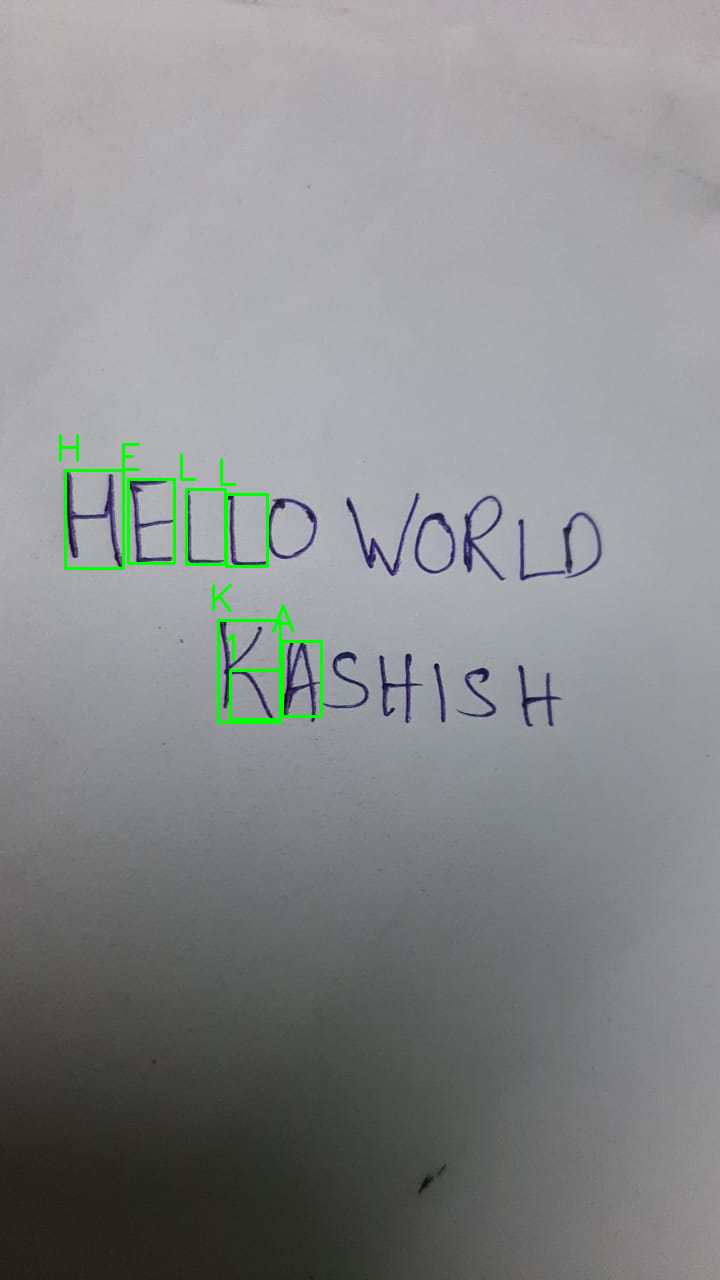

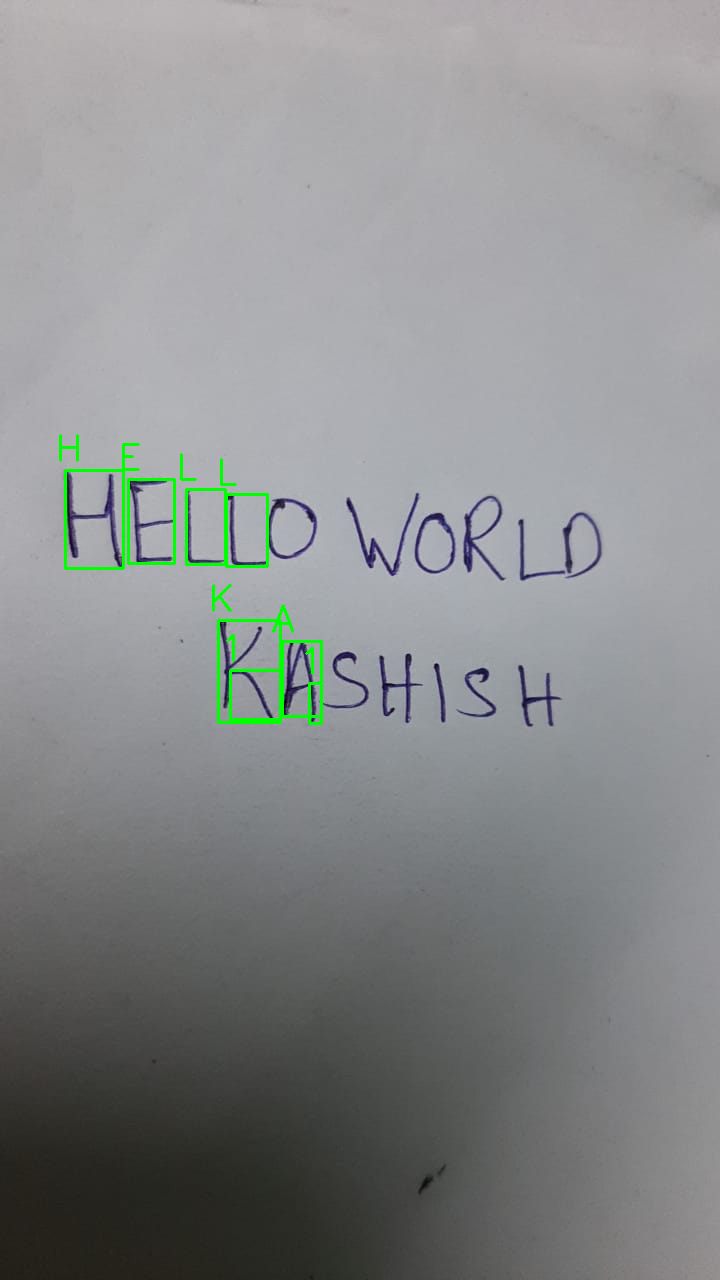

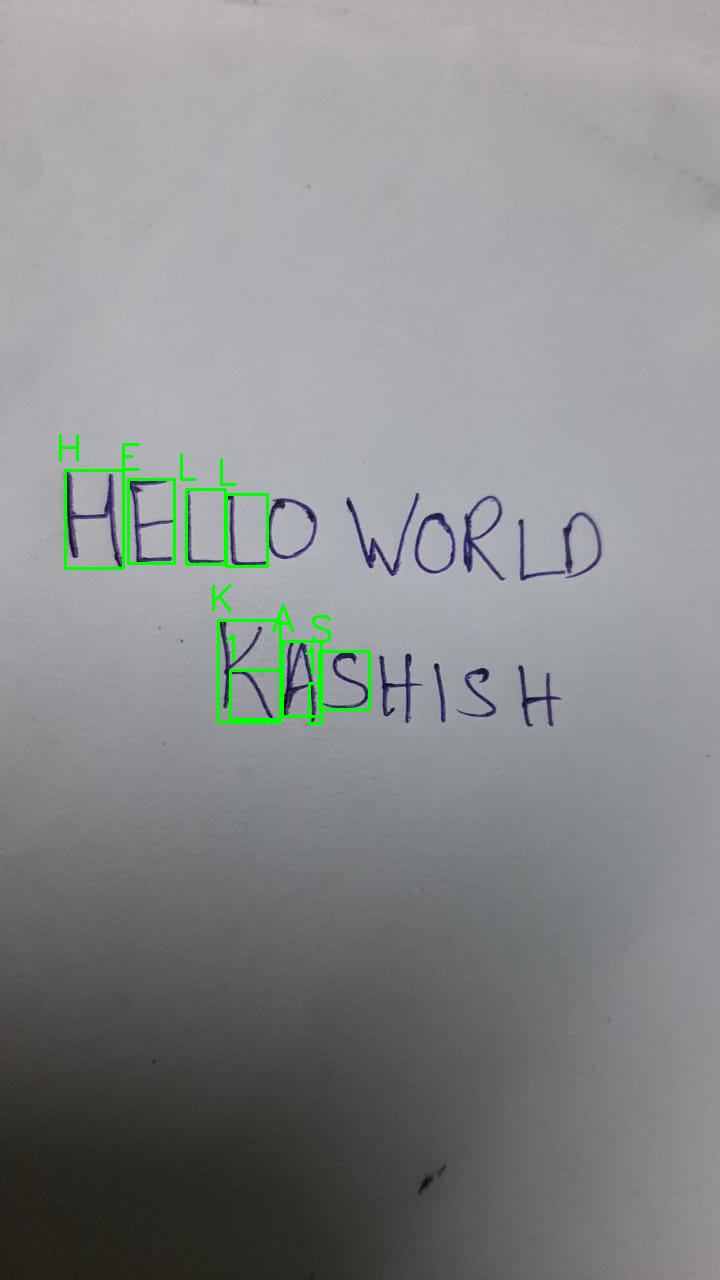

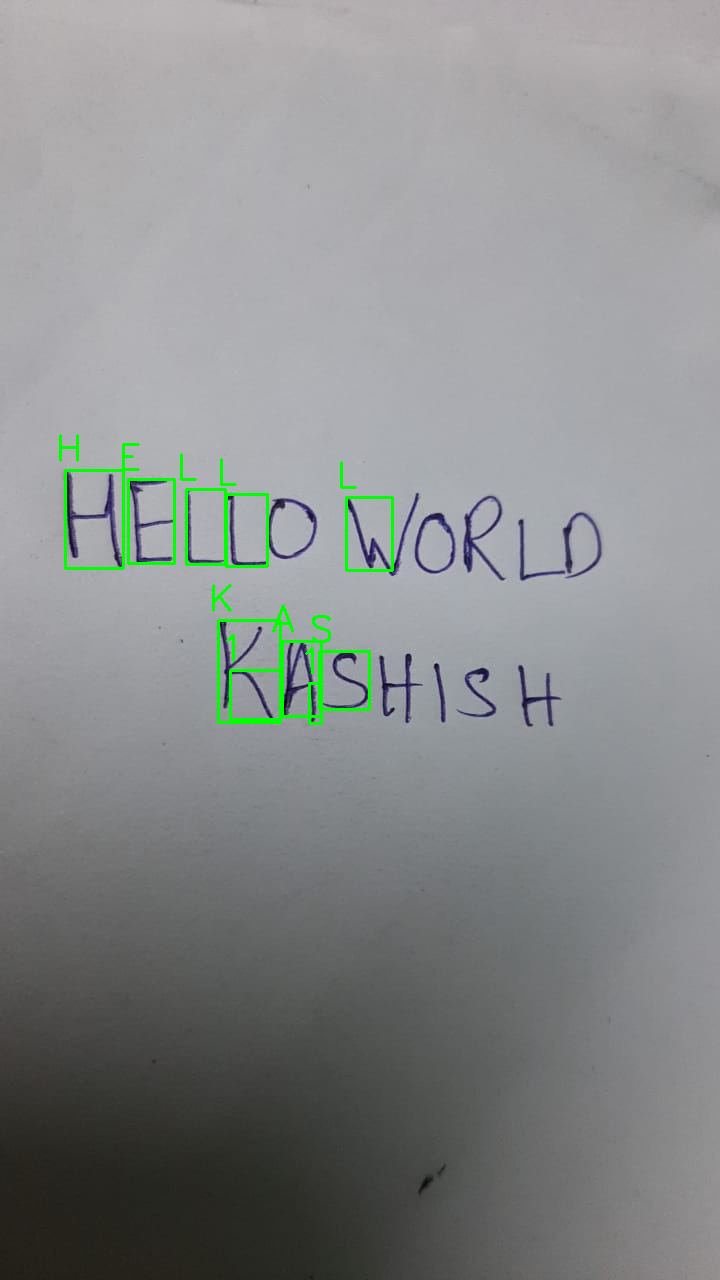

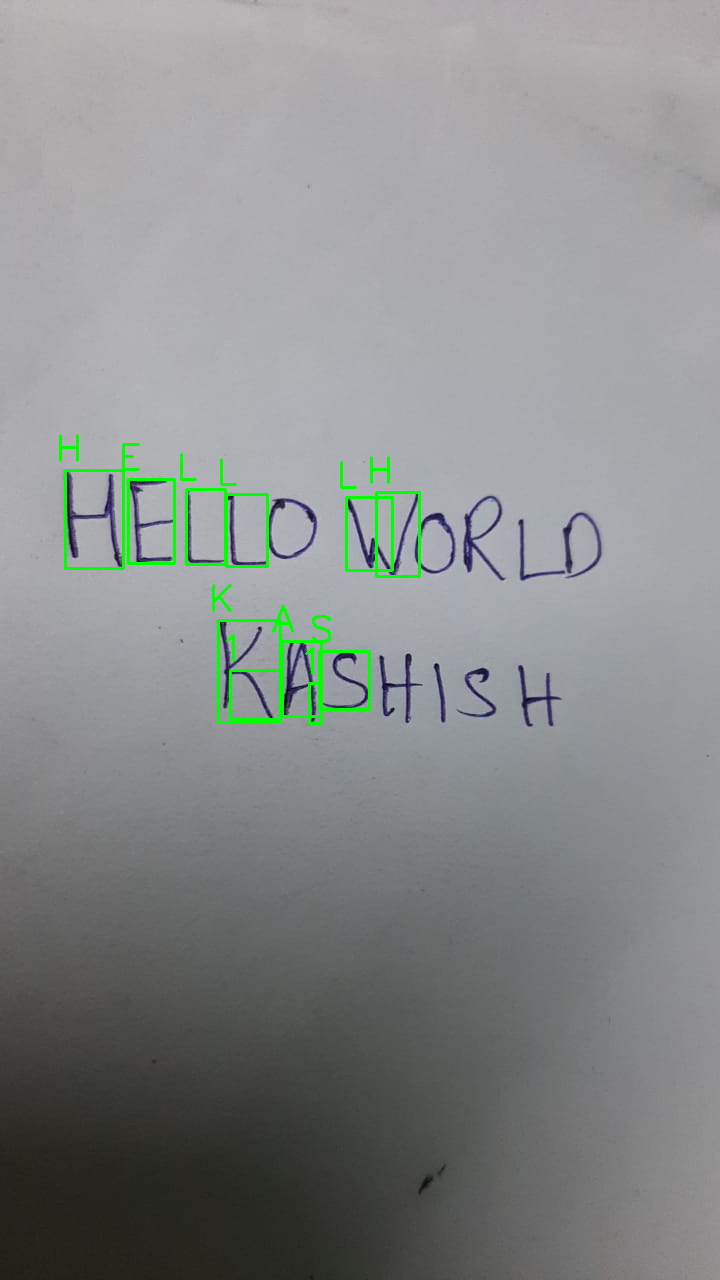

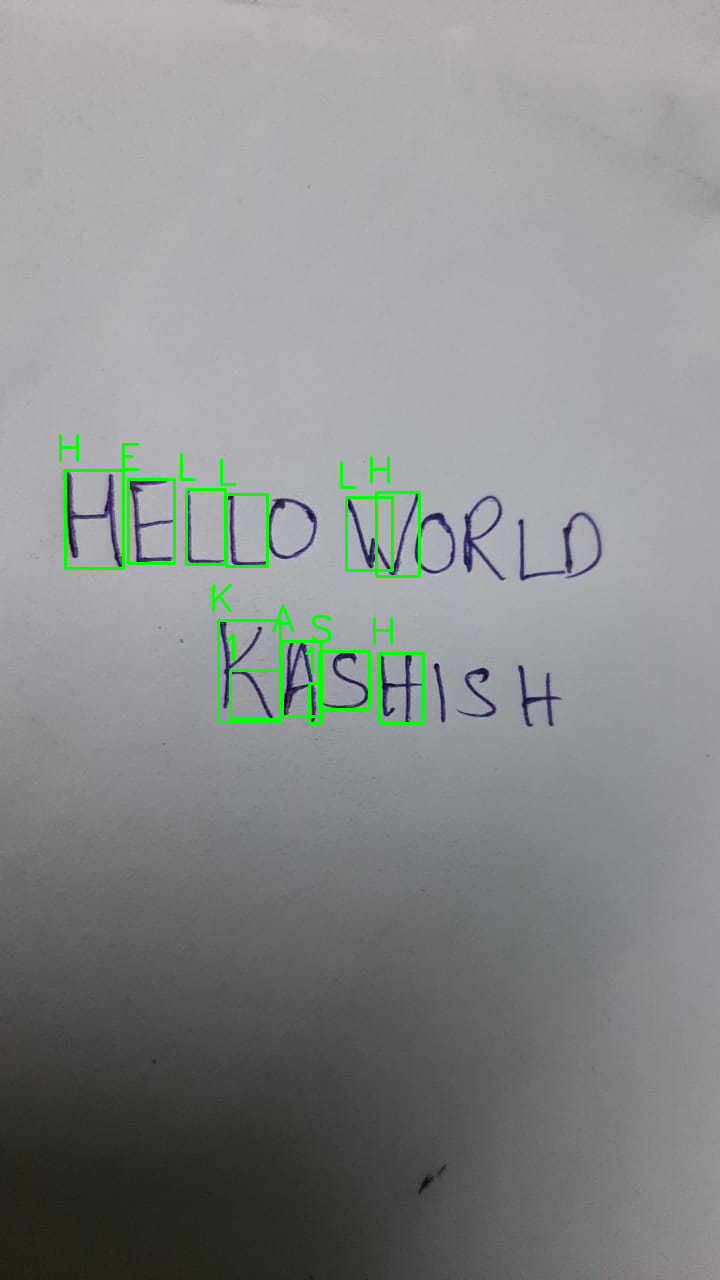

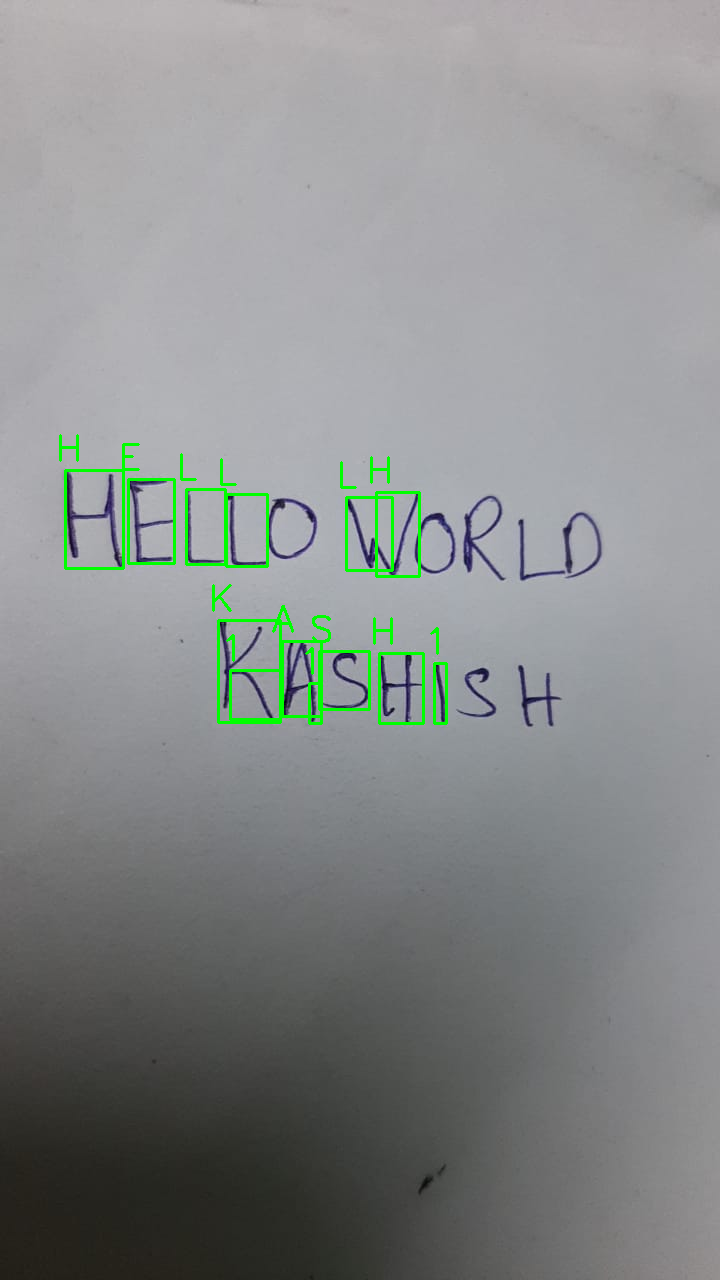

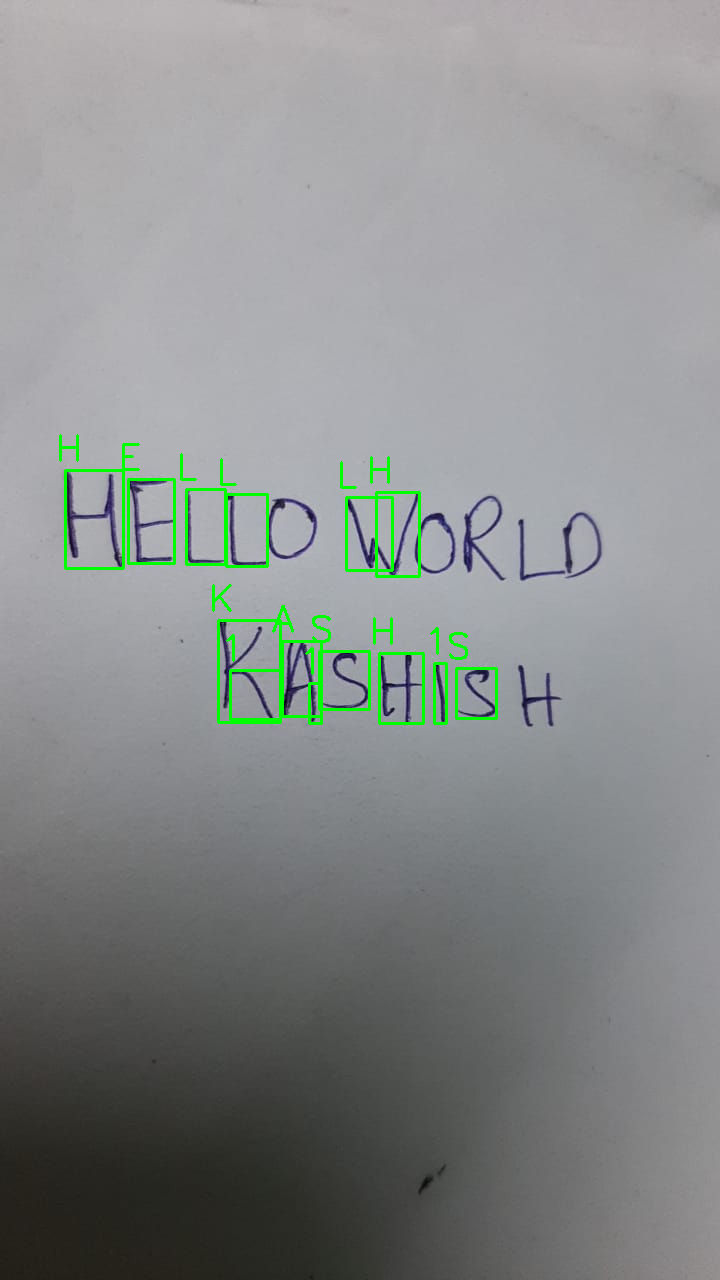

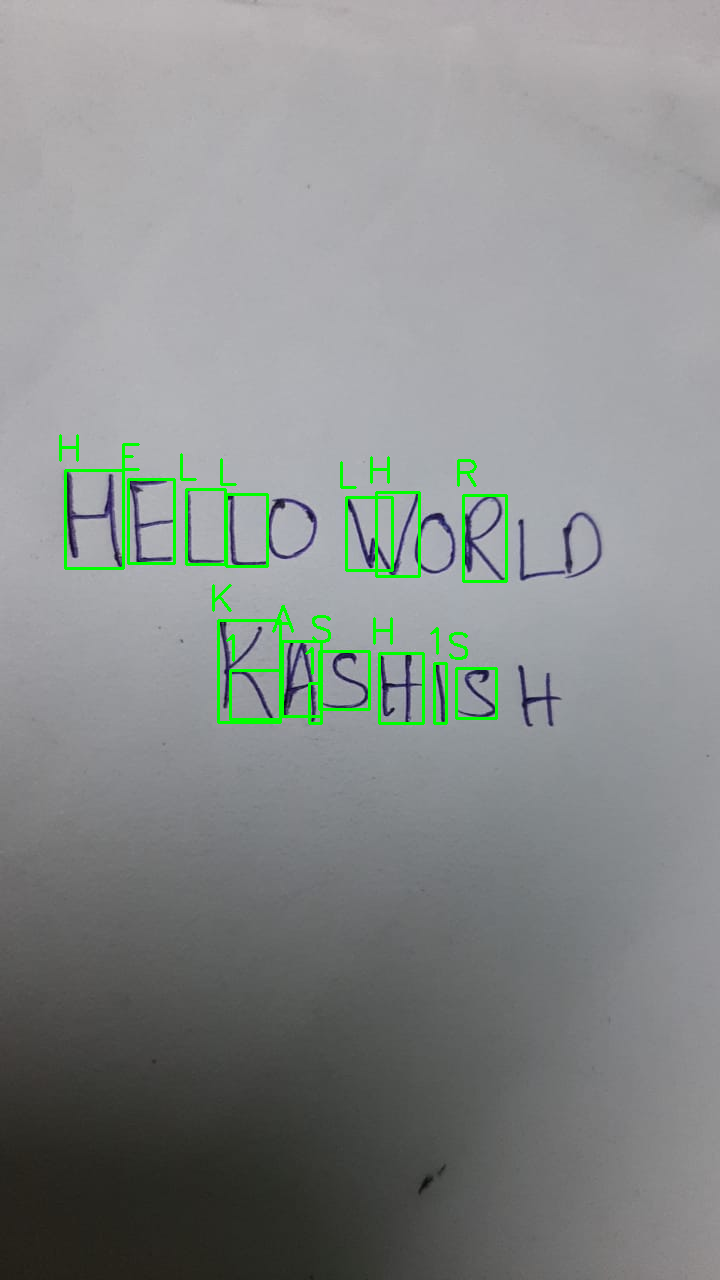

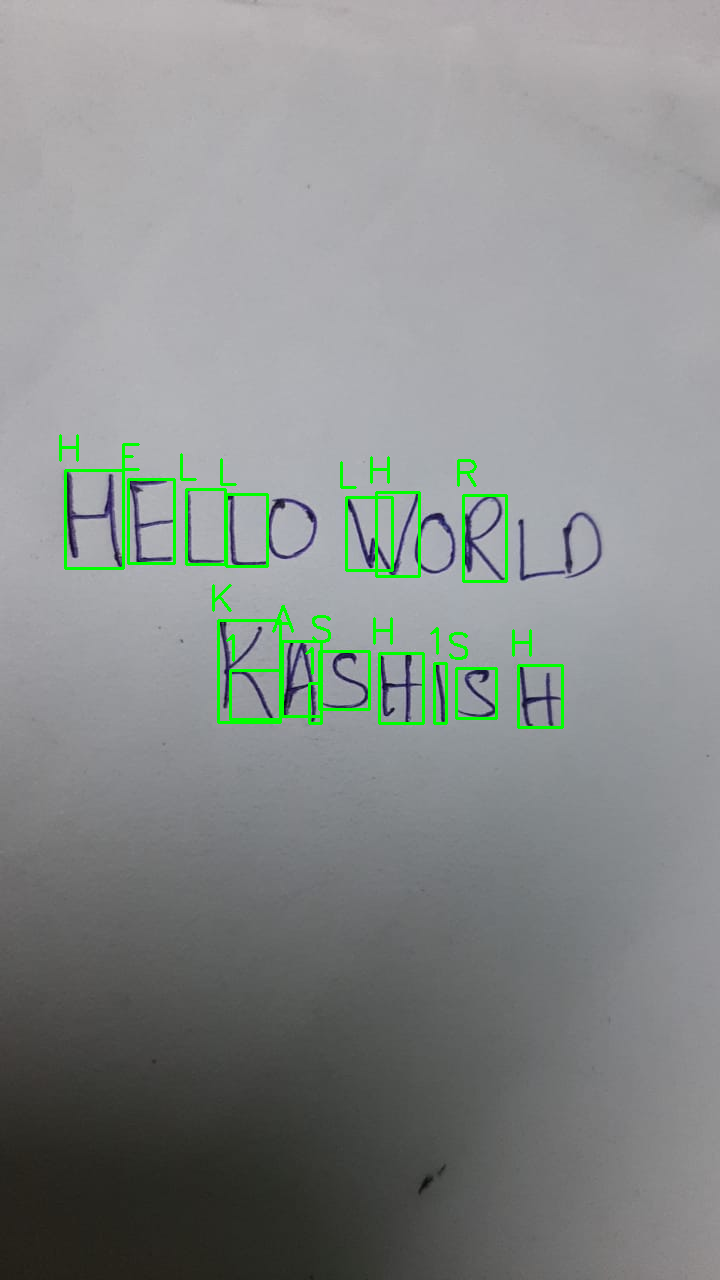

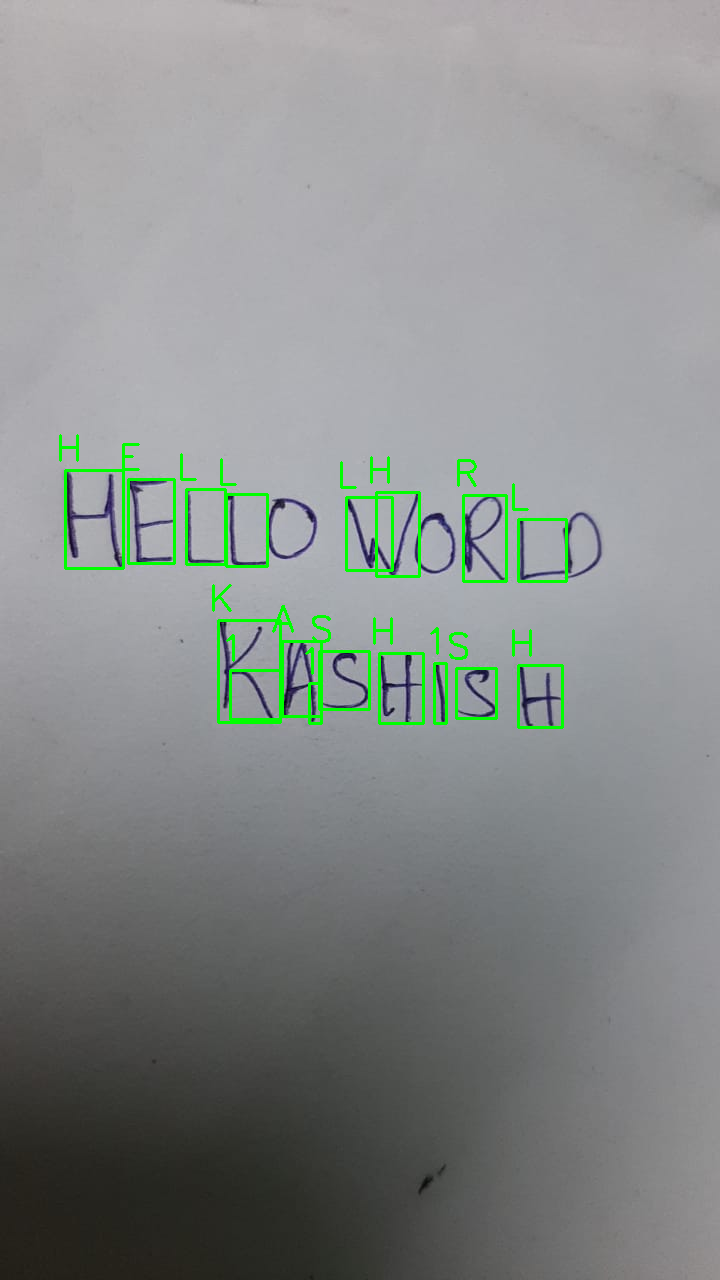

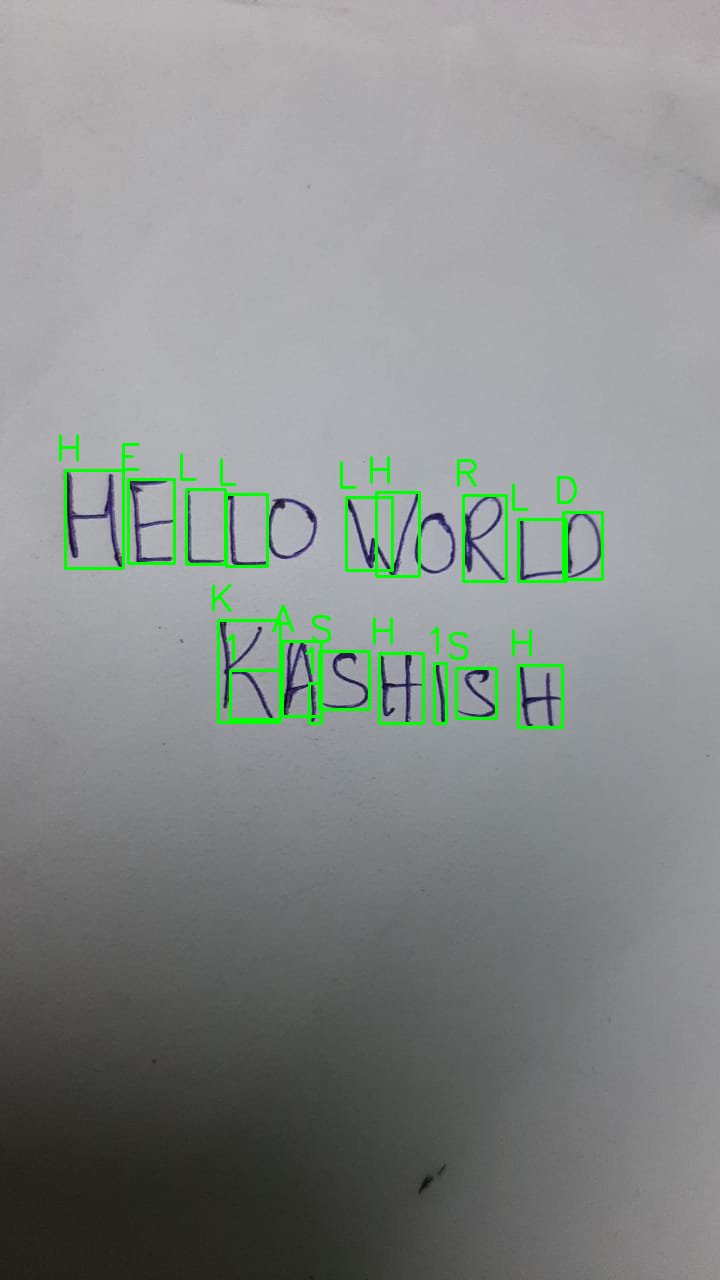

0.13988026847403615
[INFO] H - 100.00%
2


0.3692515826016384
Good
[INFO] E - 99.99%
18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


0.32040154087884254
Good
[INFO] L - 100.00%
17
20


0.0058613142903233655
Bad
[INFO] K - 99.99%
13


0.20122448011117233
Good
[INFO] L - 100.00%
17
20


-0.016457676135438686
Bad
[INFO] 1 - 97.58%
1


0.014517936538123256
Bad
[INFO] O - 94.35%
[INFO] A - 99.38%
0


0.349103815405869
Good
[INFO] N - 81.16%
[INFO] 1 - 99.92%
1


-0.052995134170013086
Bad
[INFO] S - 98.44%
16


0.2430133696414198
Good
[INFO] L - 51.42%
17
20


-0.05939255761155021
Bad
[INFO] H - 32.88%
2


-0.005576795648945287
Bad
[INFO] H - 100.00%
2


0.25166367429884845
Good
[INFO] 0 - 88.81%
[INFO] 1 - 100.00%
1


0.015469940186602693
Bad
[INFO] S - 99.84%
16


0.24834036538731558
Good
[INFO] R - 80.03%
12


0.11122614232776835
Bad
[INFO] H - 100.00%
2


0.24278311355446872
Good
[INFO] L - 99.97%
17
20


0.00756945794943583
Bad
[INFO] D - 99.93%
11


0.2616472169730798
Good


In [35]:
c=0
count=0
p=0
for (pred, (x, y, w, h)) in zip(preds, boxes):	
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]
	# draw the prediction on the image
  # print("[INFO] {} - {:.2f}%".format(label, prob * 100))
  x1=0
  y1=0
  w1=0
  h1=0
	# print(label)
  for zi in range(0,25):
	  if(save[zi]==label):
	    # print(zi)
	    (x1,y1,w1,h1)=(bosx[zi])

	# cv2.rectangle(image1, (x, y), (x + w, y + h), (0, 255, 0), 2)
	# cv2.putText(image1, label, (x - 10, y - 10),
	# 	cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
  img_res = image1[y:y+h,x:x+w]
  img_res = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
  img_res = cv2.resize(img_res,(14,14))
  img_res1 = image[y1:y1+h1,x1:x1+w1]
	# print(img_res1)
  def mse(imageA, imageB):
	  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	  err /= float(imageA.shape[0] * imageA.shape[1])
	  return err
	  
  def compare_images(imageA, imageB):
    # compute the mean squared error and structural similarity
    # index for the images
	  m = mse(imageA, imageB)
   	# ss = measure.compare_ssim(imageA, imageB)
	  s = measure.compare_ssim(imageA, imageB)
	  return s
  if(img_res1.size != 0):
	  
	  img_res1 = cv2.cvtColor(img_res1, cv2.COLOR_BGR2GRAY)
	  img_res1 = cv2.resize(img_res1,(14,14))
	  cv2.rectangle(image1, (x, y), (x + w, y + h), (0, 255, 0), 2)
	  cv2.putText(image1, label, (x - 10, y - 10),
	  cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
	  cv2_imshow(image1)
	  ss=compare_images(img_res,img_res1)
	  c=c+ss
	  count=count+1
	  p=c/count

# print("pPPP")
print(p)
for (pred, (x, y, w, h)) in zip(preds, boxes):	
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]
	# draw the prediction on the image
  print("[INFO] {} - {:.2f}%".format(label, prob * 100))
  x1=0
  y1=0
  w1=0
  h1=0
	# print(label)
  for zi in range(0,25):
	  if(save[zi]==label):
	    print(zi)
	    (x1,y1,w1,h1)=(bosx[zi])
  img_res = image1[y:y+h,x:x+w]
  img_res = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)

  img_res = cv2.resize(img_res,(14,14))
  img_res1 = image[y1:y1+h1,x1:x1+w1]
	# print(img_res1)
  def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
	  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	  err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
	  return err
	  
  def compare_images(imageA, imageB):
	  m = mse(imageA, imageB)
	  s = measure.compare_ssim(imageA, imageB)
	  print(s)
	  return s

  if(img_res1.size != 0):
	  
	  img_res1 = cv2.cvtColor(img_res1, cv2.COLOR_BGR2GRAY)
	  img_res1 = cv2.resize(img_res1,(14,14))
	  
	  # ss=compare_images(img_res,img_res1)
	  cv2_imshow(img_res)
	  cv2_imshow(img_res1)
	  ss=compare_images(img_res,img_res1)
	  if(ss>p):
	    print("Good")
	  else:
	    print("Bad")


    
	  

	  

	